In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import stumpy

# A little bit of Theory
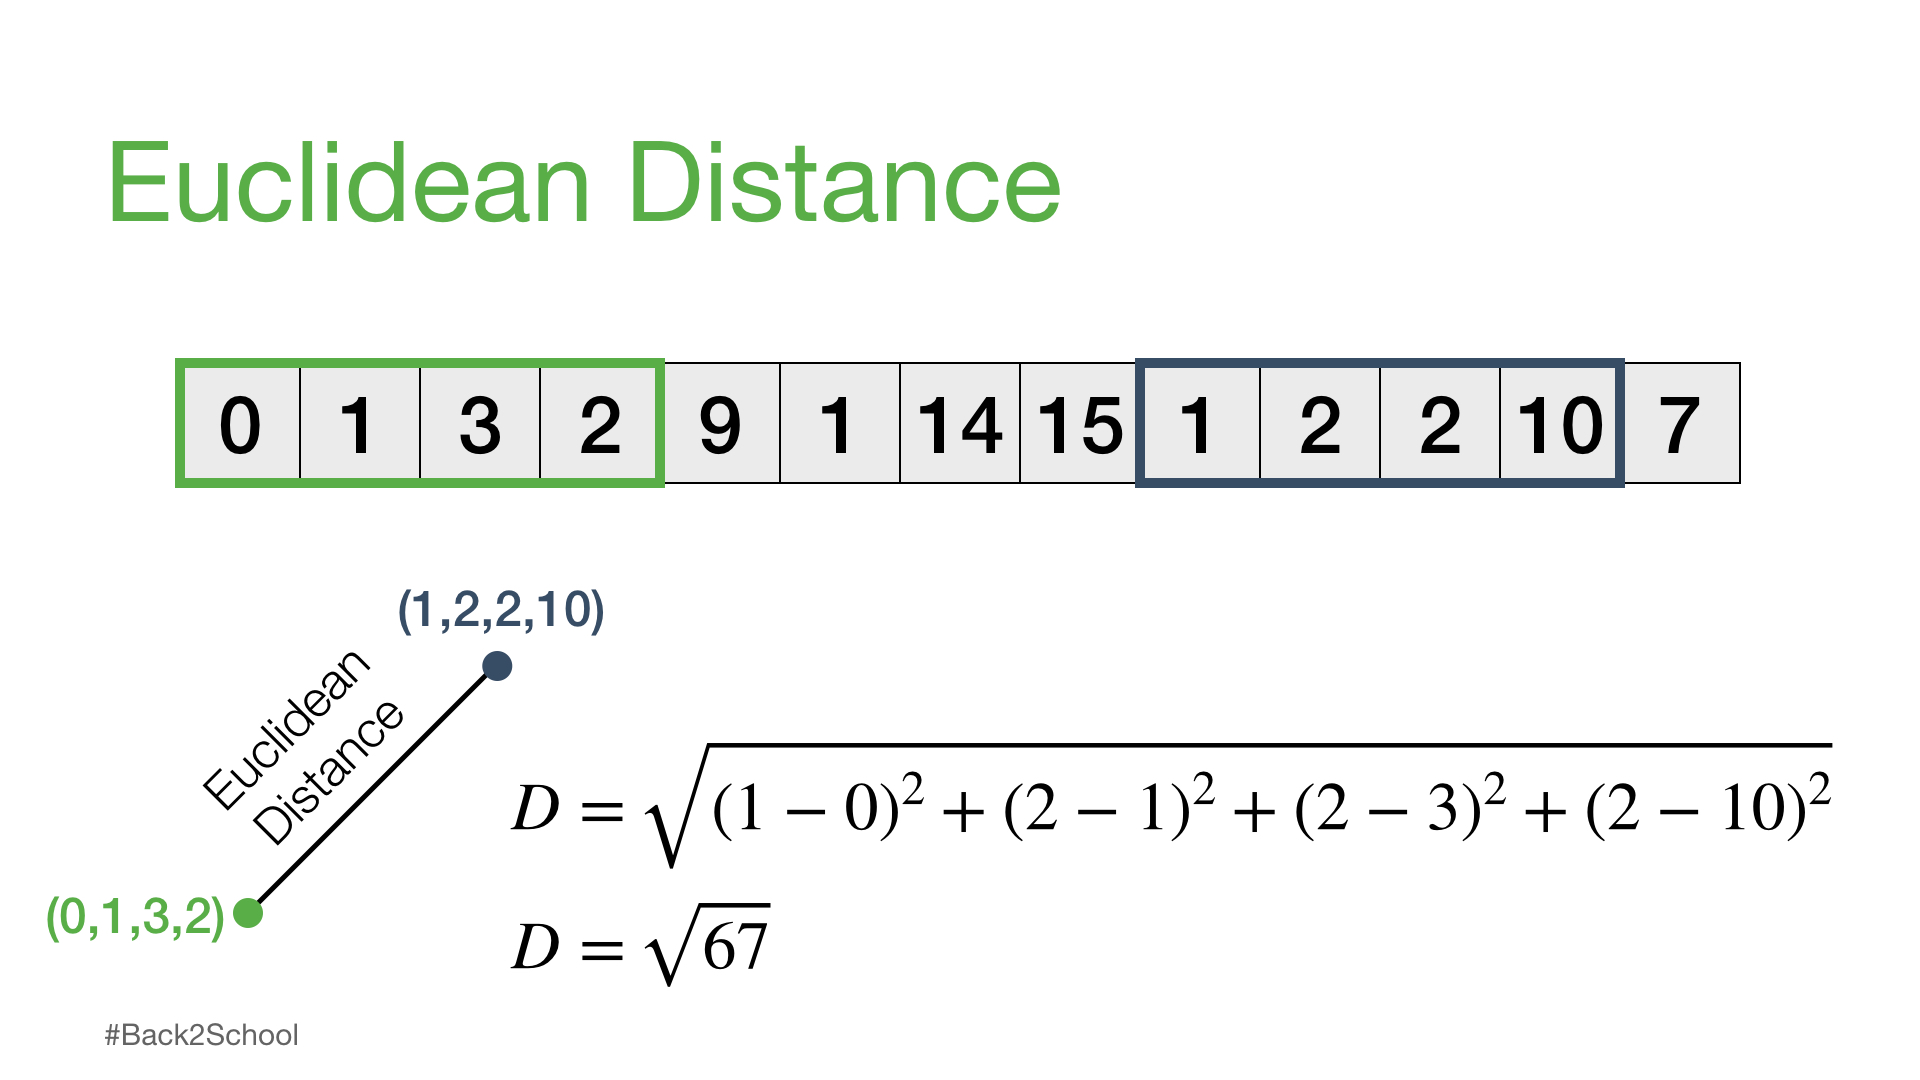
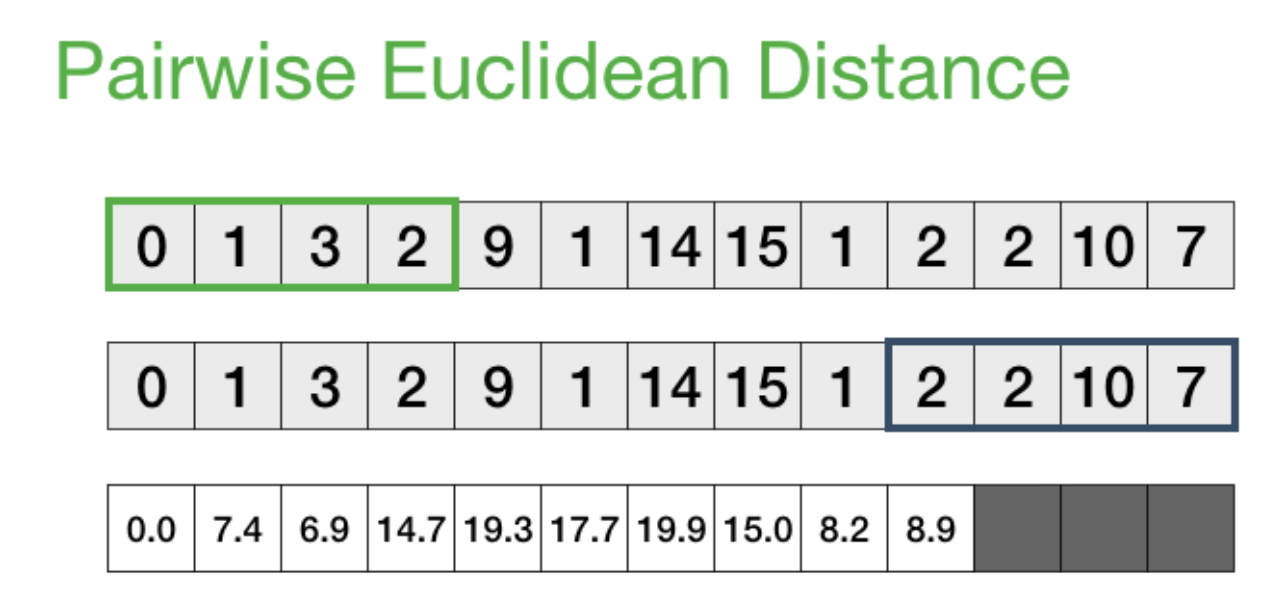

more information: [https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html](http://)

Vector that stores the (z-normalized) Euclidean distance between any subsequence within a time series and its nearest neighbor
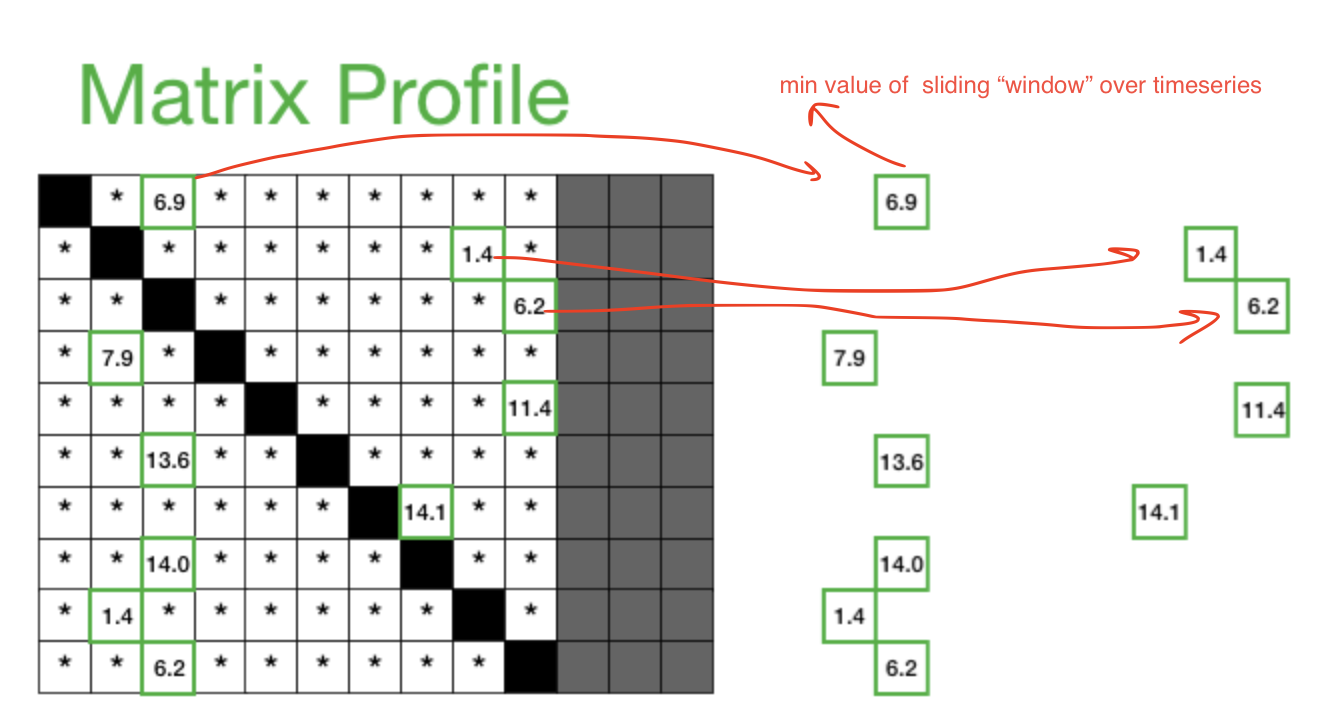


In [84]:
signal_df = pd.read_csv("/kaggle/input/example-cardio-signal-ecg/output_ecg.csv",delimiter=';')

#pd.to_datetime(signal_df['Data'],dayfirst='True')

signal_df.head()

,time,ecg_value
0,0.000,496
1,0.001,496
2,0.002,497
3,0.003,498
4,0.004,498


In [85]:
signal_df = signal_df.astype(float)

y_ts = signal_df['ecg_value']
x = signal_df.index
signal_df.head()

,time,ecg_value
0,0.000,496.0
1,0.001,496.0
2,0.002,497.0
3,0.003,498.0
4,0.004,498.0


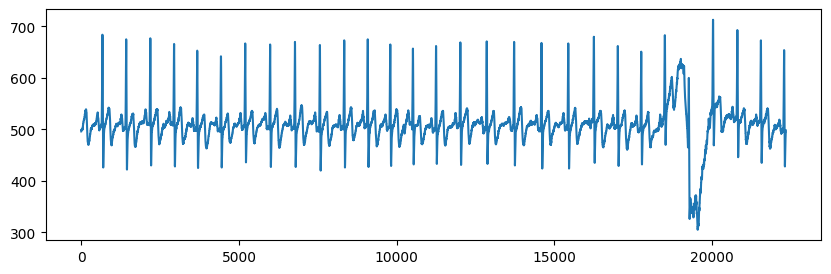

In [86]:
plt.figure(figsize=(10,3))
plt.plot(x,y_ts)

# Detrending

In [87]:
# модули для обработки временных рядов (убрать тренд и аппроксимировать)
class Detrending:
  def plot(t,y_ts,slope,intercept):
    fig = plt.figure(figsize=(10,7))
    ax = plt.subplot(111)
    plt.scatter(t,y_ts, s=5)
    plt.plot(t, slope*t + intercept, 'r',
             label='y_ts={:.2f}x+{:.2f}'.format(slope,intercept))
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlabel('time')
    plt.ylabel('Y')
    plt.show()

  def line_fit(t,y_ts):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y_ts)
    #line = slope*t + intercept
    return slope, intercept

  def trend_off(t,y_ts):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y_ts)
    line = slope*t + intercept

    y_nontrend = y_ts-line
    return y_nontrend

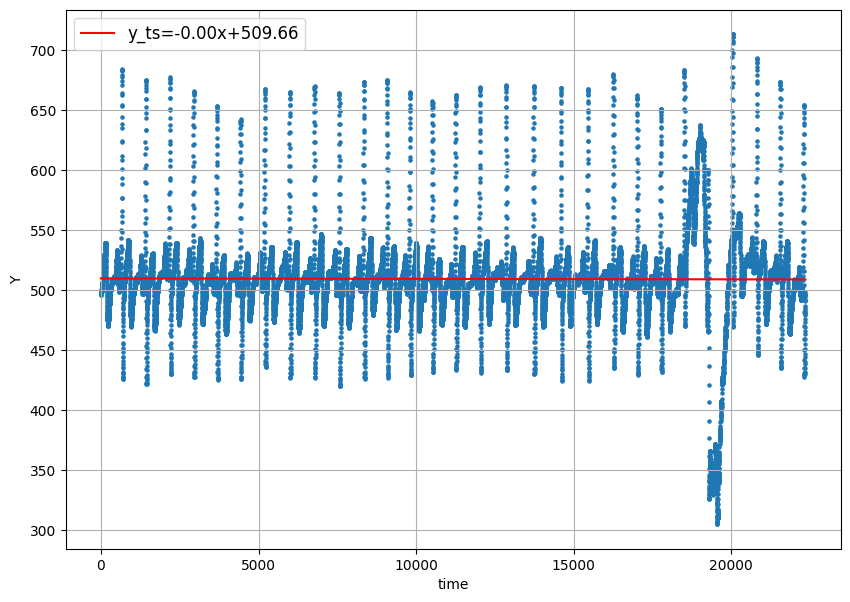

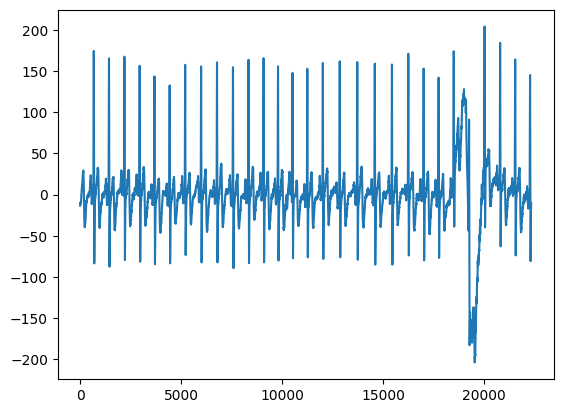

In [88]:
slope, intercept = Detrending.line_fit(x, y_ts)
Detrending.plot(x,y_ts,slope, intercept)

y_ts = Detrending.trend_off(x,y_ts)
plt.plot(x,y_ts)

# Fourier filtering

In [89]:
from numpy.fft import *

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

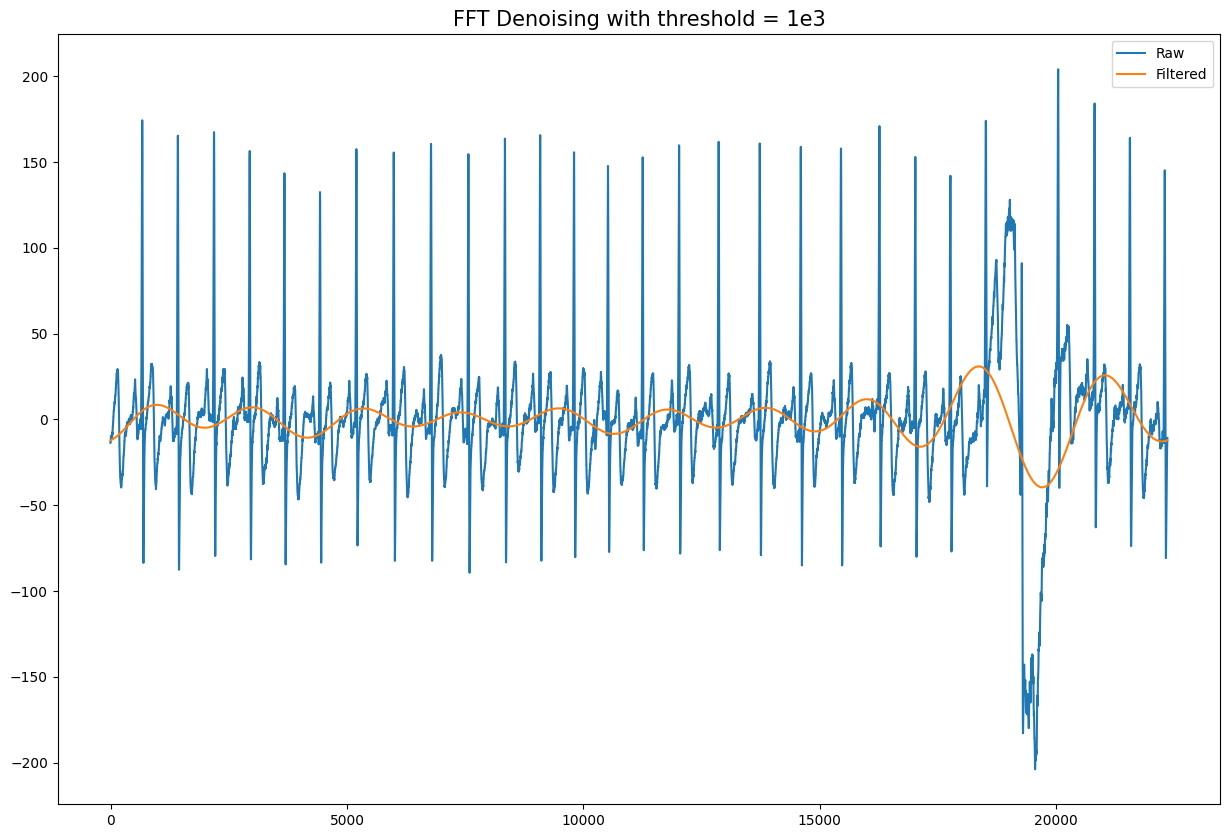

In [90]:
filtered = filter_signal(y_ts, threshold=500)
plt.figure(figsize=(15, 10))
plt.plot(y_ts, label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e3", size=15)
plt.show()

# enveloping

In [91]:
#from scipy.fft import fft, ifft
def my_func_hilbert(x):
    N = len(x)
    xf = rfft(x)
    xf[1:N//2] *= 2
    if N % 2 == 1:
        xf[N//2] *= 2
    xf[N//2 + 1:] = 0
    xa = irfft(xf)
    #assert np.allclose(xa.real, x, atol=1e-10, rtol=1e-10)
    return xa

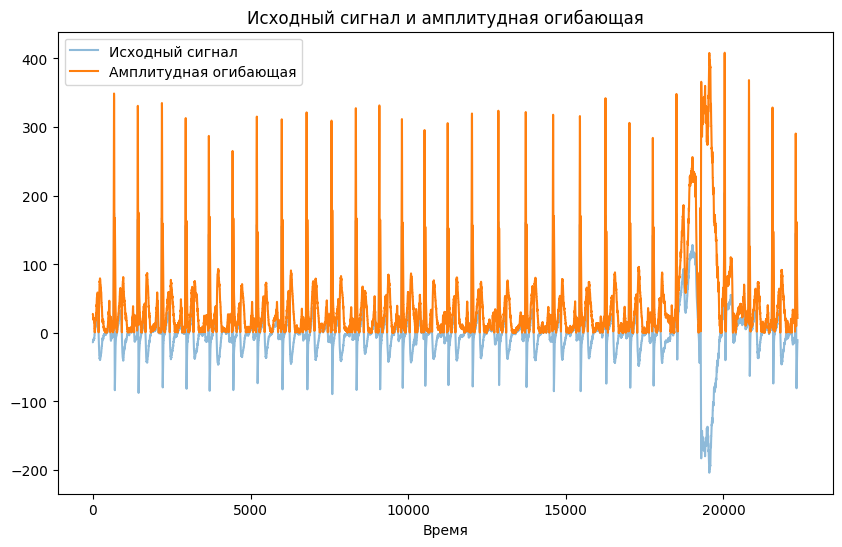

In [92]:
# Применяем преобразование Гильберта
analytic_signal = my_func_hilbert(y_ts)
amplitude_envelope = np.abs(analytic_signal)  # Используем амплитуду для амплитудной огибающей

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(x, y_ts, label='Исходный сигнал', alpha=0.5)
plt.plot(x, amplitude_envelope, label='Амплитудная огибающая')


plt.title('Исходный сигнал и амплитудная огибающая')
plt.xlabel('Время')
plt.legend()

plt.show()

# Stumpy library

In [93]:
y_ts_detrended = y_ts - filtered

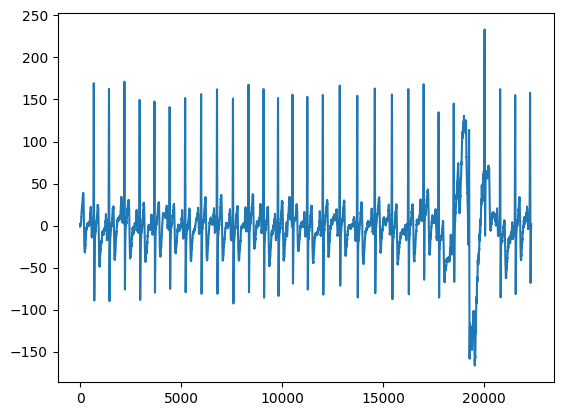

In [94]:
plt.plot(x,y_ts_detrended)

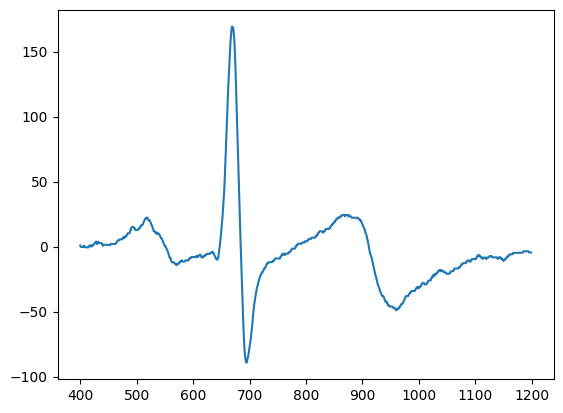

In [95]:
#let's plot one cycle of ECG signal
t0=400
tk=1200
plt.plot(x[t0:tk],y_ts_detrended[t0:tk])

In [96]:
len(y_ts_detrended)

22350

In [97]:
m = 200 #size of the sliding window its a 1/4 of a ECG period
matrix_profile = stumpy.stump(y_ts_detrended, m)
#matrix_profile

<BarContainer object of 22151 artists>

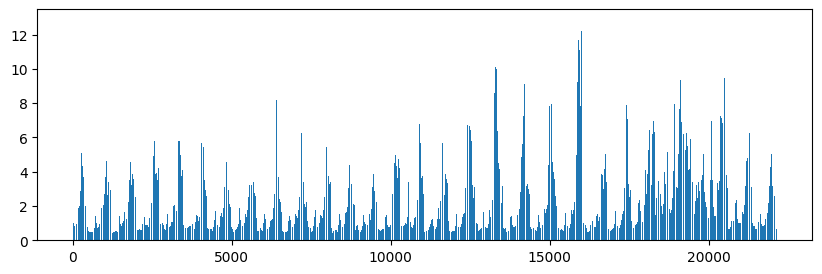

In [103]:
matrix_profile_df = pd.DataFrame(matrix_profile, columns=['profile', 
                                                          'profile index', 
                                                          'left profile index', 
                                                          'right profile index'])

best_motif = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
best_motifmatrix_profile_df = pd.DataFrame(matrix_profile, columns=['profile', 
                                                                    'profile index',
                                                                    'left profile index',
                                                                    'right profile index'])

matrix_profile_df.head(10)
plt.figure(figsize=(10,3))
#plt.plot(matrix_profile_df['profile'],'.')
plt.bar(matrix_profile_df.index,matrix_profile_df['profile'])

In [38]:
best_motif = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
best_motif

,profile,profile index,left profile index,right profile index
1259,0.394659,8175,506,8175
8175,0.394659,1259,1259,11088


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

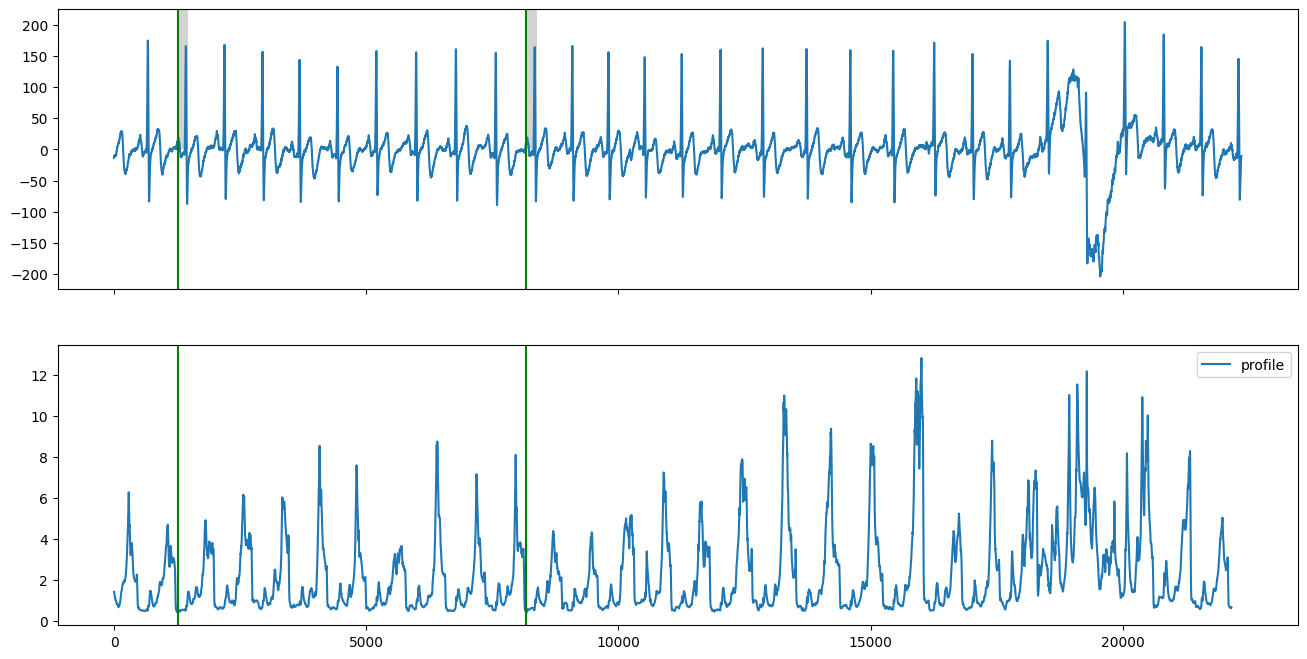

In [59]:
#The best motif is the one where the profile is the smallest (since the profile is the distance value)

profile_df = matrix_profile_df[['profile']]

fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y_ts=y_ts, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])

for idx in best_motif.index.to_list():
    g1.axvline(x=idx, color="green")
    g2.axvline(x=idx, color="green")
    rect = Rectangle((idx, 0), m, round(y_ts_detrended.max(),0), facecolor="lightgrey")
    g1.add_patch(rect)

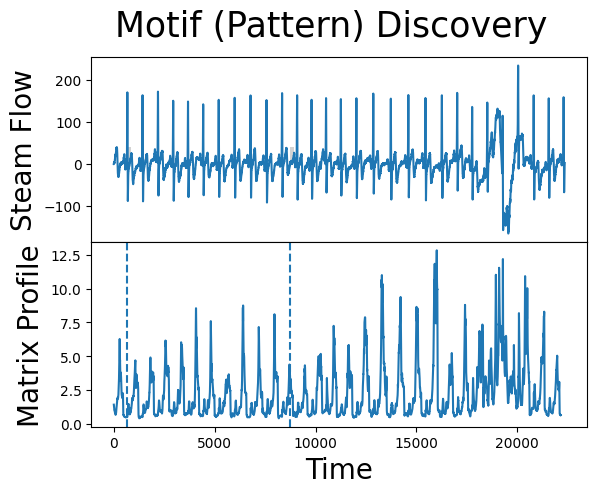

In [60]:
# another case ti visualize timeseries and profile of distance (matrix_profile)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='25')

#axs[0].plot(steam_df['steam flow'].values)
axs[0].plot(y_ts_detrended)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=643, linestyle="dashed")
axs[1].axvline(x=8724, linestyle="dashed")
axs[1].plot(matrix_profile_df['profile'])
plt.show()

Upload txt file OpenSingal format, transform to dataframe pandas format 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

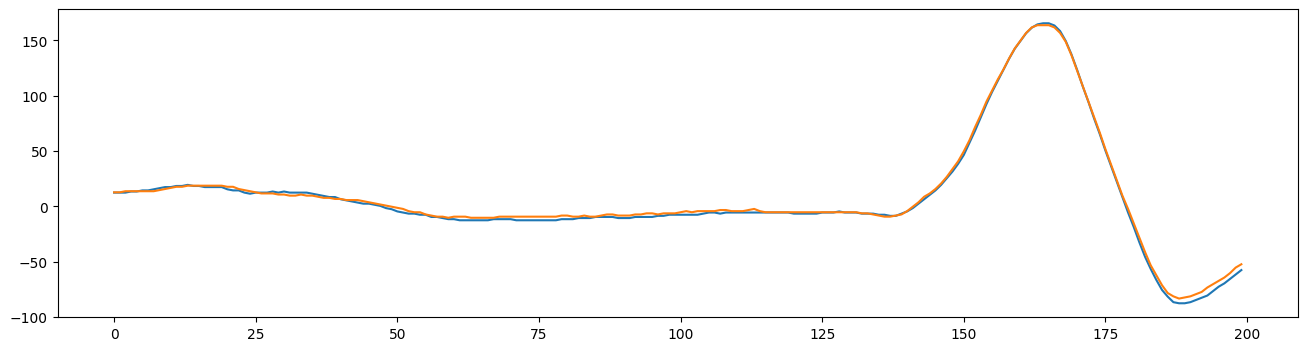

In [61]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in best_motif.index.to_list():
    plot_y = y_ts.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

## **Find a Discord**

Potential discords/anomalies can be located as data that's most different to any existing datapoints, this can be found by finding the max profile distance. We can find the anomaly segment by getting this value and plotting it below:

In [62]:
discord = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].max()]
discord

,profile,profile index,left profile index,right profile index
16006,12.84087,3568,3568,16909


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

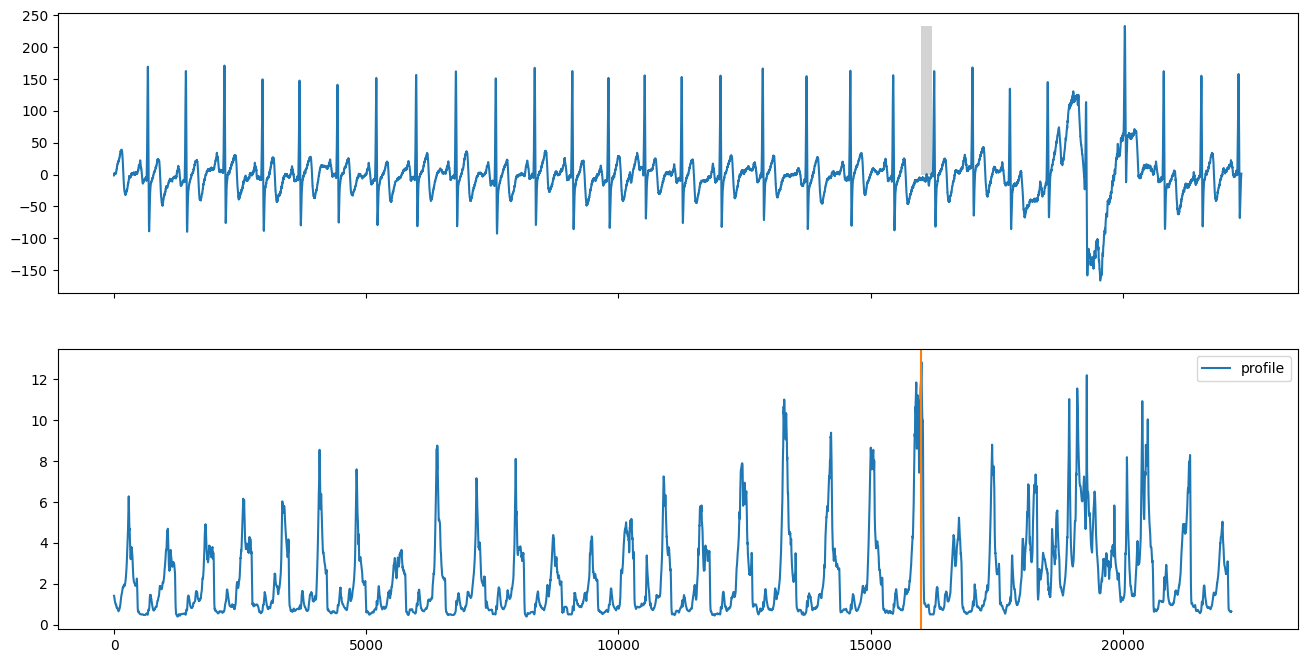

In [69]:
fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y_ts=y_ts_detrended, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])


rect = Rectangle((discord.index[0], 0), m, round(max(y_ts_detrended),0), facecolor="lightgrey")
g1.add_patch(rect)
g2.axvline(x=[discord.index[0]], color='C1')

# Chain of timeseries

A Time series chain can be visualized as a set of motifs that have a close match in some direction. We can calculate the chains in the dataset by using the allc function which also returns the unanchored chain (longest chain) which takes the left profile index and the right profile index:

In [72]:
all_chain_set, unanchored_chain = stumpy.allc(matrix_profile[:, 2], 
                                              matrix_profile[:, 3])

unanchored_chain

array([  584,  6691, 15361, 17674, 20724])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


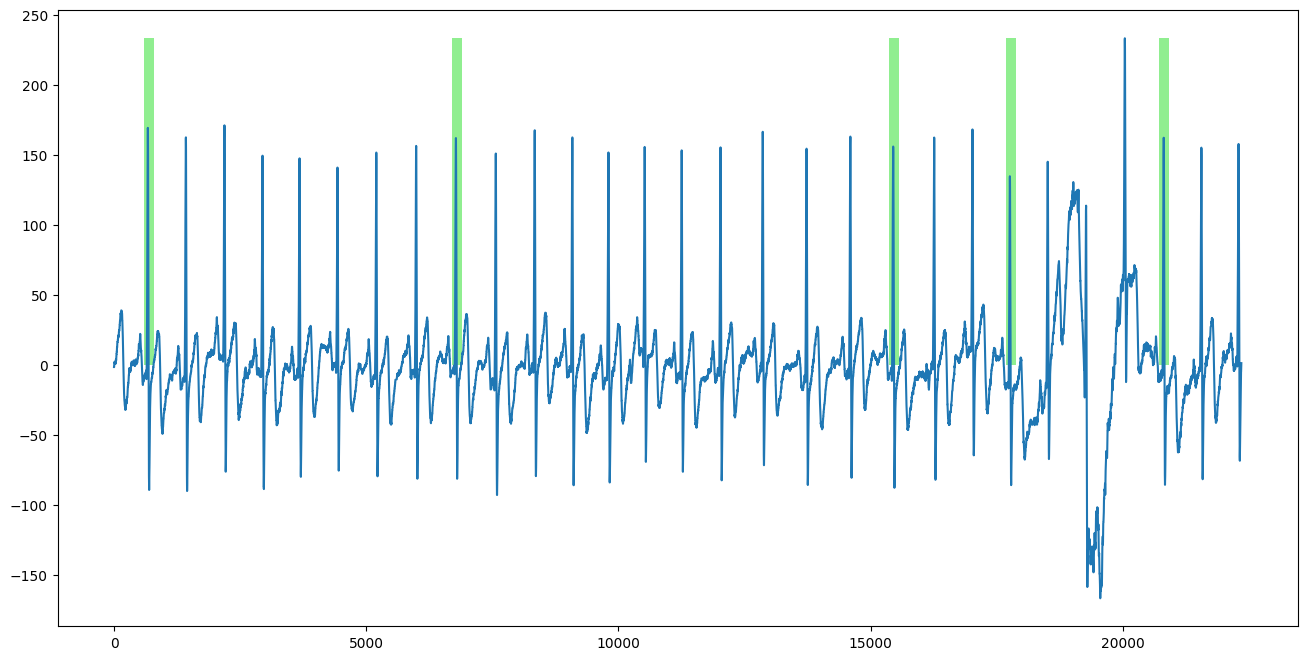

In [75]:
fig, ax = plt.subplots(figsize=(16,8), sharex=True)

sns.lineplot(data=y_ts_detrended)

for idx in unanchored_chain:
    rect = Rectangle((idx, 0), m, round(max(y_ts_detrended),2), facecolor="lightgreen")
    ax.add_patch(rect)

In the above we can see the growing pattern but we can also see sections where the matrix profile is small which means there is minimal difference between subsequences

# Find regimes in timeseries

Note that the segments account for segmentation between regimes - i.e. there is a split in the relationship of the data on each side of the input data - the two parts have their own profile relations

In [79]:
L = m
regimes = 5
cac, regime_locations = stumpy.fluss(matrix_profile[:, 1], 
                                     L=L, 
                                     n_regimes=regimes, 
                                     excl_factor=1)

In [80]:
regime_locations

array([21950, 18265, 17840, 18049])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

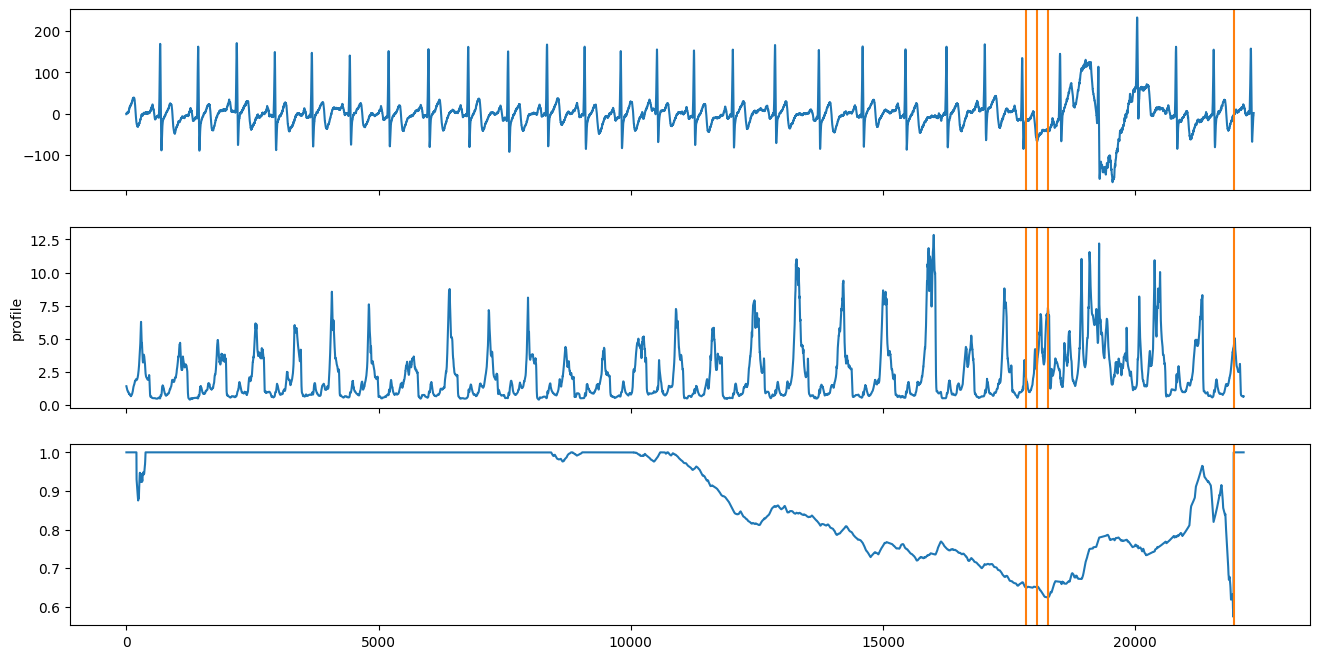

In [81]:
regime_locationsfig, ax = plt.subplots(3, figsize=(16,8), sharex=True)

sns.lineplot(data=y_ts_detrended, ax=ax[0])
sns.lineplot(data=matrix_profile_df['profile'], ax=ax[1])
sns.lineplot(data=cac, ax=ax[2])

for idx in regime_locations:
    for adx in ax:
        adx.axvline(x=idx, color='C1')

# Future usufull works

**1. Building a Shapelet Based Model**
It's possible to build a model from the shapelets we defined by defining a classifier that uses the euclidien distance (matrix profile) to the shapelet in order to figure out which shapelet is the best, but first, we need to define a way to get the distance of the shapelet since this is what will be used to train the model

**2. Consensus Motifs**
Consensus motifs are patterns that are conserved across all time series within a set. The Ostinato algorithm is an efficient way of finding consensus motifs.


**3. Fast Pattern Matching**
We can use STUMPY to find predefined patterns in data, this can also be much more efficient than trying to find general patterns in a dataset.

https://stumpy.readthedocs.io/en/latest/Tutorial_Time_Series_Chains.html